# Курсовой проект
## Теория вероятностей и математической статистики

Анализ базы турнирных шахматных партий.

### Сбор данных

Используя библиотеку python-chess, распарсим pgn-файл с шахматными партиями и экспортируем их в csv.

In [42]:
import chess.pgn
import csv
import re

In [ ]:
pgn = open("KingBase2019-A40-A79.pgn")
with open('chess.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['date', 'result', 'white_elo', 'black_elo', 'moves',])
    game = chess.pgn.read_game(pgn)
    while game:
        if game.headers['Result'] == '1-0':
            result = 1
        elif game.headers['Result'] == '0-1':
            result = -1
        else:
            result = 0
        writer.writerow([
            game.headers['Date'], 
            result, 
            int(game.headers['WhiteElo']), 
            int(game.headers['BlackElo']),
            int(re.search(r'^\d+', str(game.end())).group(0)),
        ])
        game = chess.pgn.read_game(pgn)

### Обзор данных

In [148]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

In [27]:
data = pd.read_csv('chess.csv')
data.loc[lambda df: df.result > 0, 'winner_elo'] = data.loc[lambda df: df.result > 0, 'black_elo']
data.loc[lambda df: df.result < 0, 'winner_elo'] = data.loc[lambda df: df.result < 0, 'white_elo']
data.loc[lambda df: df.result < 0, 'loser_elo'] = data.loc[lambda df: df.result < 0, 'black_elo']
data.loc[lambda df: df.result > 0, 'loser_elo'] = data.loc[lambda df: df.result > 0, 'white_elo']
data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'winner_elo_diff'] = data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'winner_elo'] - data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'loser_elo']
data['elo_diff'] = data['white_elo'] - data['black_elo']
data.head(5)

,date,result,white_elo,black_elo,moves,winner_elo,loser_elo,winner_elo_diff,elo_diff
0,2018.12.31,0,2436,2240,24,NaN,NaN,NaN,196
1,2018.12.31,0,2228,2544,36,NaN,NaN,NaN,-316
2,2018.12.31,1,2438,2189,42,2189.0,2438.0,-249.0,249
3,2018.12.31,0,2485,2547,66,NaN,NaN,NaN,-62
4,2018.12.31,-1,2289,2484,59,2289.0,2484.0,-195.0,-195


* `date` – дата, когда состоялась партия
* `result` $\in$ (-1, 0, +1) – кто победил, соответственно: белые, ничья, чёрные
* `white_elo` – рейтинг elo белого игрока
* `black_elo` – рейтинг elo чёрного игрока
* `moves` – количество ходов в партии
* `winner_elo` – рейтинг elo победителя
* `loser_elo` – рейтинг elo проигравшего
* `winner_elo_diff` – разница между рейтингом elo победителя и проигравшего
* `elo_diff` – разница между рейтингом elo игроков, играющих за белый и чёрный цвет соответственно

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35706 entries, 0 to 35705
Data columns (total 8 columns):
date               35706 non-null object
result             35706 non-null int64
white_elo          35706 non-null int64
black_elo          35706 non-null int64
moves              35706 non-null int64
winner_elo         24639 non-null float64
loser_elo          24639 non-null float64
winner_elo_diff    24639 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 2.2+ MB


### Исследуем колонку moves

Найдём выборочные среднее, дисперсию, стантартное квадратическое отклонение и моду:

In [4]:
n = data.moves.count()
print('n =', n)

avg = data.moves.mean()
print('avg =', avg)

n = 35706
avg = 43.57189267910155


In [5]:
var = data.moves.var(ddof=1)
print('var =', var)

std = data.moves.std(ddof=1)
print('std =', std)

var = 309.75426275011193
std = 17.599837009191646


In [6]:
mode = data.moves.mode()[0]
print('mode =', mode)

mode = 40


In [7]:
data.moves.value_counts()

40     1176
41     1040
39      983
35      975
38      965
       ... 
163       1
168       1
174       1
166       1
159       1
Name: moves, Length: 150, dtype: int64

Посчитаем межквартильный интервал и построим boxplot

In [8]:
q1 = data.moves.quantile(0.25)
print('q1 =', q1)

median = data.moves.median()
print('median =', median)

q3 = data.moves.quantile(0.75)
print('q3 =', q3)

p90 = data.moves.quantile(0.90)
print('p90 =', p90)

iqr = (q3 - q1) * 1.5
print('iqr =', iqr)

(q1 - iqr, q3 + iqr)

q1 = 32.0
median = 41.0
q3 = 53.0
p90 = 66.0
iqr = 31.5


(0.5, 84.5)

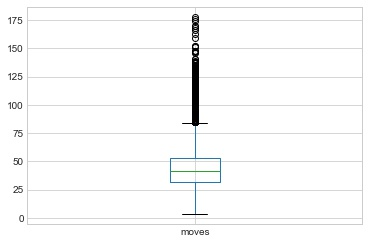

In [42]:
data.boxplot(column='moves')

### Функция распределения

Построим эмпирическую функцию распределения:

In [10]:
def edf(samples, x: float) -> float:
    return samples[samples < x].shape[0] / samples.shape[0]

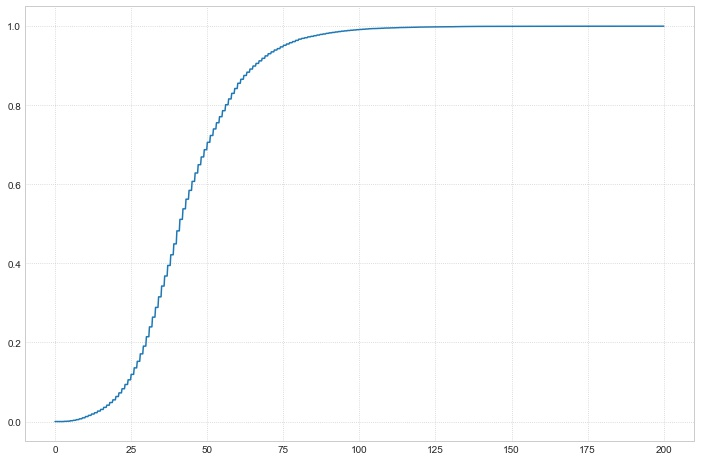

In [43]:
plt.figure(figsize=(12, 8))

ox = np.linspace(0, 200, 1000)
oy = np.array([edf(data.moves, x) for x in ox])

plt.plot(ox, oy)

plt.grid(linestyle='dotted')
plt.show()

Построим плотность распределения и сравним её с нормальной плотностью распределения:

In [12]:
def pdf_normal(loc: float, scale: float, x: float) -> float:
    return np.exp(- ((x - loc) ** 2) / (2 * scale ** 2)) / (scale * np.sqrt(2 * np.pi))

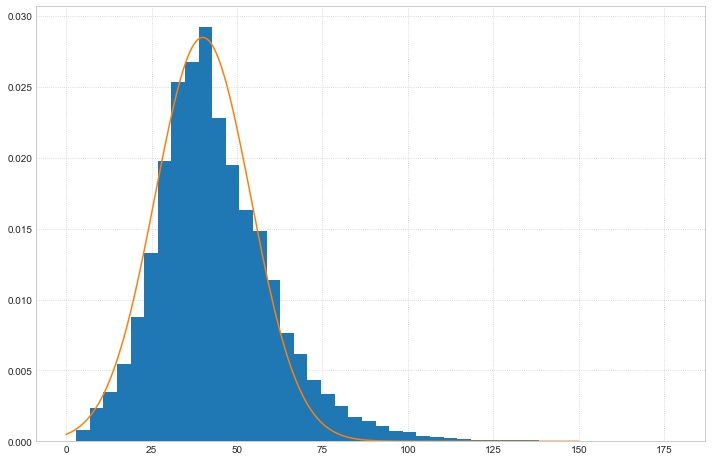

In [44]:
plt.figure(figsize=(12, 8))

ox = np.linspace(0, 150, 1000)
oy = np.array([pdf_normal(mode, 14, x) for x in ox])

plt.hist(data.moves, density=True, bins=44)
plt.plot(ox, oy)

plt.grid(linestyle='dotted')
plt.show()

### Проверка гипотезы о нормальном распределении

На графическом представлении данных видно, что распределение выборки напоминает нормальное. Проверим, что генеральная совокупность имеет нормальное распределение с $M(X) = mode = 40$ и $\sigma = 14$, приняв уровень значимости $\alpha = 0.01$.

Значение $M(X)$ взяли равной моде, как самому частовстречающемуся значению. Значение $\sigma$ было подобрано экспериментально графическим способом.

Воспользуемся критерием согласия Колмогорова:

`kstest(rvs, cdf)`

Аргументы:
* rvs – выборка,
* cdf – функция распределения.

Возвращает:
* statistic – статистика критерия,
* pvalue – число, которое имеет следующий смысл: если меньше уровня значимости $\alpha$, то гипотеза $H_0$ отвергается, в противном случае гипотеза $H_0$ не отвергается.

Источник: https://mipt-stats.gitlab.io/files/mathstats_fbmf_19/seminar4.pdf

In [14]:
mode, std, n

(40, 17.599837009191646, 35706)

In [15]:
cdf = stats.norm(loc=mode, scale=14).cdf

In [16]:
kstest = stats.kstest(rvs=data.moves, cdf=cdf, alternative='greater')
kstest

KstestResult(statistic=0.0, pvalue=1.0)

In [17]:
alpha = 0.01
kstest.pvalue > alpha

True

Распределение является нормальным.

### Корреляционный анализ

In [18]:
data.dropna()[['moves', 'winner_elo', 'winner_elo_diff']].corr()

,moves,winner_elo,winner_elo_diff
moves,1.000000,0.109673,0.133336
winner_elo,0.109673,1.000000,0.540927
winner_elo_diff,0.133336,0.540927,1.000000


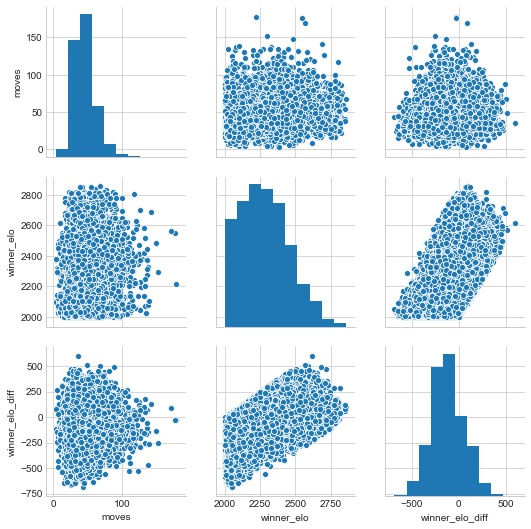

In [45]:
sns.pairplot(data.dropna()[['moves', 'winner_elo', 'winner_elo_diff']])

Мы видим, небольшую положительную корелляцию между количеством ходов, сделанных в партии, и уровнем elo победителя. Так как корреляция Пирсона показывает линейную зависимость, то можно сделать вывод, что более высокоуровневые игроки чаще играют долгие партии.

Также наблюдаем положительную корелляцию между количеством ходов, сделанных в партии, и разницей elo игроков. Получается, что победить игрока с рейтингом ниже своего – не всегда задача из лёгких.

### Модель определения победителя по разнице в рейтинге между игроками

Попытаемся обучить модель логистической регрессии определять победителя партии в зависимости от разности в рейтинге между игроками и количеством ходов в партии. Для начала визуализируем имеющиеся данные:

In [36]:
win_data = data[['result', 'elo_diff', 'moves']][lambda df: df.result != 0]

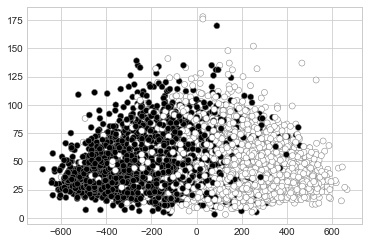

In [153]:
plt.scatter(win_data.elo_diff, win_data.moves, color=[('white' if (i == 1) else 'black') for i in win_data.result], edgecolor="gray", linewidth=0.5)
plt.show()

Обучим модель:

In [50]:
model = LogisticRegression(solver='liblinear')

model.fit(win_data[['elo_diff', 'moves']], win_data.result)
b_ = model.coef_.flatten()

model.coef_, model.n_iter_

(array([[ 0.00774705, -0.00272061]]), array([9], dtype=int32))

Визуализируем прямую логистичекой регрессии и построим градиент уверенности модели:

In [115]:
xx, yy = np.mgrid[-700:700:10, 0:200:10]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

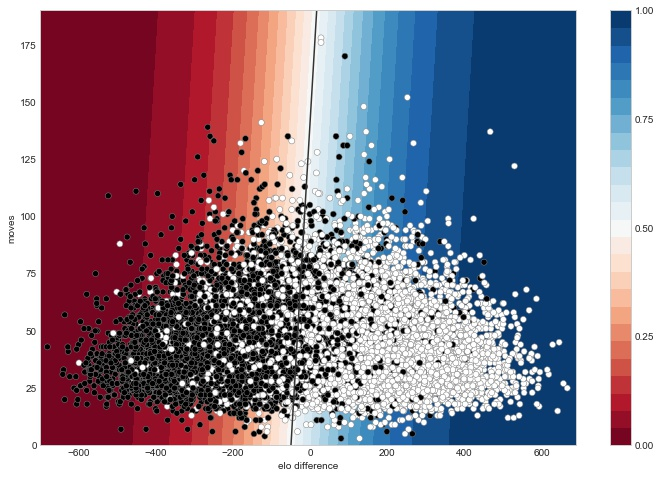

In [151]:
f, ax = plt.subplots(figsize=(12, 8))

ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(win_data.elo_diff, win_data.moves,
           color=[('white' if (i == 1) else 'black') for i in win_data.result], 
           cmap="RdBu", edgecolor="gray", linewidth=0.5)

ax.set(xlabel="elo difference", ylabel="moves")
plt.show()

Посчитаем r2:

In [149]:
predicted = model.predict(win_data[['elo_diff', 'moves']])
accuracy = accuracy_score(win_data.result, predicted)
print('accuracy:', accuracy)

accuracy: 0.7646008360728925


Получили довольно неплохой результат с точностью равной 76%. Можно сделать вывод, что разница в рейтинге между игроками действительно влияет на исход партии. Кроме того, можно заметить, что при небольшой разнице в рейтинге, у белых больше шансов победить на ранних этапах игры. Поэтому чёрному игроку имеет смысл затягивать партию.

### Интересные факты (Выводы)
* В среднем, на шахматном турнире игроки успевают сделать по $44$ хода.
* Партии, которые закончились на $40$ ходу, встречаются чаще, чем другие.
* $90\%$ партий заканчиваются до $66$ хода.
* Партии, у которых более $84$ ходов крайне редки. Шанс увидеть такую – меньше трёх из 100.
* Игроки с высоким рейтингом любят поиграть дольше, также, как игроки с большой разницей в рейтинге.
* Если рейтинг игрока выше, то шансы на победу всё равно близки к $\frac{1}{2}$.
* Количество ходов в партии имеет нормальное распределение.
* Чем больше разница в рейтинге между игроками, тем выше шанс победы более игрока с большим рейтингом.
* У белых больше шансов выиграть на ранней стадии игры.